<a href="https://colab.research.google.com/github/sdvargas/transformer/blob/master/2heads_50batch_trueshuffle_dataset1_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation con Redes Transformer

![Red Transformer](https://drive.google.com/uc?export=view&id=1nHAZ3WDsXYZuSPYximLx-hLa2S1zv9Cg)

In [ ]:
pip install keras-transformer


In [ ]:
import numpy as np
import os
os.environ['TF_KERAS'] = '1'
from keras_transformer import get_model, decode
from pickle import load
from google.colab import drive
np.random.seed(0)

In [ ]:
#os.listdir('/drive/MyDrive/Colab Notebooks')

In [ ]:
# Leer set de entrenamiento
drive.mount('/content/drive')
filename = '/content/drive/My Drive/Colab Notebooks/dataset.npy'

dataset = np.load(filename)
print(dataset[120000,0])
print(dataset[120000,1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
litre
litro


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Crear "tokens"
source_tokens = []
for sentence in dataset[:,0]:
  source_tokens.append(sentence.split(' '))
print(source_tokens[120000])

target_tokens = []
for sentence in dataset[:,1]:
  target_tokens.append(sentence.split(' '))
print(target_tokens[120000])

['litre']
['litro']


In [ ]:
def build_token_dict(token_list):
  token_dict = {
      '<PAD>': 0,
      '<START>': 1,
      '<END>': 2
  }
  for tokens in token_list:
    for token in tokens:
      if token not in token_dict:
        token_dict[token] = len(token_dict)
  return token_dict

In [ ]:
source_token_dict = build_token_dict(source_tokens)
target_token_dict = build_token_dict(target_tokens)
target_token_dict_inv = {v:k for k,v in target_token_dict.items()}

print(len(source_token_dict))
print(len(target_token_dict))
print(len(target_token_dict_inv))

95532
110263
110263


In [ ]:
len(source_token_dict)

In [ ]:
# Agregar start, end y pad a cada frase del set de entrenamiento
encoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
decoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in target_tokens]
output_tokens = [tokens + ['<END>'] for tokens in target_tokens]

source_max_len = max(map(len, encoder_tokens))
target_max_len = max(map(len, decoder_tokens))

encoder_tokens = [tokens + ['<PAD>']*(source_max_len-len(tokens)) for tokens in encoder_tokens]
decoder_tokens = [tokens + ['<PAD>']*(target_max_len-len(tokens)) for tokens in decoder_tokens]
output_tokens = [tokens + ['<PAD>']*(target_max_len-len(tokens)) for tokens in output_tokens ]

In [ ]:
print(encoder_tokens[120000])

In [ ]:
encoder_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encoder_tokens]
decoder_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decoder_tokens]
output_decoded = [list(map(lambda x: [target_token_dict[x]], tokens)) for tokens in output_tokens]

print(encoder_input[120000])

[1, 53982, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Crear la red transformer
model = get_model(
    token_num = max(len(source_token_dict),len(target_token_dict)),
    embed_dim = 32,
    encoder_num = 2,
    decoder_num = 2,
    head_num = 4,
    hidden_dim = 128,
    dropout_rate = 0.05,
    use_same_embed = False,
)
model.compile('adam', 'sparse_categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder-Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder-Token-Embedding (Embedd [(None, None, 32), ( 3528416     Encoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Embedding (TrigPosEmbed (None, None, 32)     0           Encoder-Token-Embedding[0][0]    
__________________________________________________________________________________________________
Encoder-1-MultiHeadSelfAttentio (None, None, 32)     4224        Encoder-Embedding[0][0]          
______________________________________________________________________________________________

In [ ]:
#from keras.callbacks import ModelCheckpoint
#from sklearn.model_selection import train_test_split

In [14]:
#    Entrenamiento
#x = np.hstack((np.array(encoder_input), np.array(decoder_input)))
#y = np.array(output_decoded)
#x_trainNP,x_testNP,y_train,y_test=train_test_split(x,y,test_size=0.2)
#x_train=[x_trainNP[:,0:49],x_trainNP[:,49:]]
#X_test=[x_testNP[:,0:49],x_testNP[:,49:]]
x = [np.array(encoder_input), np.array(decoder_input)]
y = np.array(output_decoded)
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/tp'
output_path = os.path.join(DATA_PATH,'output2')
if not os.path.exists(output_path):
    os.makedirs(output_path)
filename = os.path.join(output_path)
#checkpoint = ModelCheckpoint(filepath=filename, monitor='loss', verbose=1,
#    save_best_only=True, mode='auto', save_freq=1)

history=model.fit(x,y, epochs=15, batch_size=50,validation_split=0.1,shuffle=False)

#filename = '/content/drive/My Drive/videos/2020-07-06/translator.h5'
#model.load_weights(filename)

Epoch 1/15
4259/4259 [==============================] - 751s 174ms/step - loss: 0.5300 - val_loss: 0.6467
Epoch 2/15
4259/4259 [==============================] - 745s 175ms/step - loss: 0.4589 - val_loss: 0.6186
Epoch 3/15
4259/4259 [==============================] - 742s 174ms/step - loss: 0.4305 - val_loss: 0.5934
Epoch 4/15
4259/4259 [==============================] - 745s 175ms/step - loss: 0.4101 - val_loss: 0.5897
Epoch 5/15
4259/4259 [==============================] - 744s 175ms/step - loss: 0.3979 - val_loss: 0.5815
Epoch 6/15
4259/4259 [==============================] - 745s 175ms/step - loss: 0.3910 - val_loss: 0.5702
Epoch 7/15
4259/4259 [==============================] - 747s 175ms/step - loss: 0.3853 - val_loss: 0.5687
Epoch 8/15
4259/4259 [==============================] - 744s 175ms/step - loss: 0.3811 - val_loss: 0.5724
Epoch 9/15
4259/4259 [==============================] - 744s 175ms/step - loss: 0.3770 - val_loss: 0.5676
Epoch 10/15
4259/4259 [=======================

dict_keys(['loss', 'val_loss'])


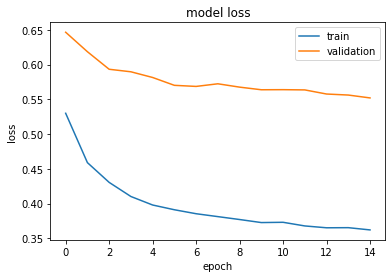

In [15]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
def translate(sentence):
  sentence_tokens = [tokens + ['<END>', '<PAD>'] for tokens in [sentence.split(' ')]]
  tr_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in sentence_tokens][0]
  decoded = decode(
      model, 
      tr_input, 
      start_token = target_token_dict['<START>'],
      end_token = target_token_dict['<END>'],
      pad_token = target_token_dict['<PAD>']
  )

  print('Frase original: {}'.format(sentence))
  print('Traducción: {}'.format(' '.join(map(lambda x: target_token_dict_inv[x], decoded[1:-1]))))

In [17]:
translate('the day is warm and sunny')

Frase original: the day is warm and sunny
Traducción: el dia de tom esta dos horas


In [18]:
translate('i am tired of college')

Frase original: i am tired of college
Traducción: tom fue a la fiesta


In [ ]:
a='why this net doesnt work Right'
a=a.lower()
translate(a)
model.save("2heads_50batch_trueshuffle_dataset1.9")